In [1]:
import re
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoProcessor
from datasets import load_dataset
from transformers import AutoModelForVision2Seq, AutoProcessor
import torch

In [3]:
import os
import json
from datasets import load_dataset

def build_filtered_dataset(dataset_name='derek-thomas/ScienceQA',
                           split='validation',
                           keep_grades='1-6',
                           image_save_dir='val_filtered_images1-6'):
    """
    构建按年级和图像存在性过滤的数据集，并保存图像到本地文件夹。

    返回:
        List[Dict]: 可写入 JSON 的样本列表，每个样本包含图像路径。
    """
    os.makedirs(image_save_dir, exist_ok=True)

    def is_grade_allowed(grade_str):
        if keep_grades is None:
            return True
        try:
            grade_num = int(grade_str.replace("grade", ""))
            if keep_grades == "1-6":
                return 1 <= grade_num <= 6
            elif keep_grades == "7-12":
                return 7 <= grade_num <= 12
        except:
            return False
        return False

    data = load_dataset(dataset_name, split=split)
    dataset = []

    for i, sample in enumerate(data):
        try:
            if sample.get('question') is None or sample.get('image') is None:
                continue
            if not is_grade_allowed(sample.get("grade", "")):
                continue

            # 保存图像到本地
            image = sample["image"].convert("RGB")
            image_filename = f"{image_save_dir}/img_{i}.jpg"
            image.save(image_filename)

            # 构建样本
            solution = sample.get("solution", "")
            lecture = sample.get("lecture", "")
            solution_lecture = f"The solution and lecture are :{solution}\n\n{lecture}".strip()

            dataset.append({
                "image": image_filename,  # ✅ 写入路径，而不是 Image 对象
                "question": sample["question"],
                "choices": sample["choices"],
                "hint": sample["hint"],
                "answer": sample["answer"],
                "solution_lecture": solution_lecture,
                "grade": sample["grade"],
            })

        except Exception as e:
            print(f"跳过第 {i} 个样本，错误：{e}")
            continue

    return dataset



In [ ]:
# dataset = build_filtered_dataset(dataset_name='derek-thomas/ScienceQA',
#                                  split='validation',
#                                  keep_grades='1-6',
#                                  image_save_dir='val_filtered_images1-6')


In [ ]:
# with open("val_1-6.json", "w", encoding="utf-8") as f:
#     json.dump(dataset, f, ensure_ascii=False, indent=2)

In [6]:
import json
from PIL import Image

def build_message(sample):
    content = []
    
    if sample['image'] is not None:
        image = Image.open(sample['image']).convert("RGB")
        content.append({"type": "image", "image": image})
    
    # 基础信息构造
    question_text = f"[Question]: {sample['question']}\n"
    question_text += "[Choices]: " + " ".join(
        [f"{chr(65 + idx)}. {choice}" for idx, choice in enumerate(sample['choices'])]
    ) + "\n"

    # 模型输出
    model_output = sample.get("model_output", "")
    question_text += f"[Model Output]: {model_output}\n"

    # 正确答案
    if isinstance(sample.get("answer"), int):
        correct_letter = chr(65 + sample["answer"])
        question_text += f"[Correct Answer]: {correct_letter}\n"
    else:
        question_text += "[Correct Answer]: \n"

    # 参考解释
    question_text += f"[Reference Explanation]: {sample.get('solution_lecture', '')}\n"

    # 评分提示
    question_text += (
        "Please first state the correct answer in the format:\n"
        "The correct answer is: **[A/B/C/D]. [Answer Text]**\n\n"
        "Then, provide a step-by-step explanation of your reasoning with clarity and logical coherence."
    )

    content.append({"type": "text", "text": question_text})
    return [{"role": "user", "content": content}]



In [7]:
json_path = "val_1-6.json"  # 或你的路径 train_0.json
with open(json_path, "r", encoding="utf-8") as f:
    samples = json.load(f)
message = build_message(samples[0])
test_dataset = [build_message(sample) for sample in samples]

[{'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=606x87 at 0x7F607D26F010>}, {'type': 'text', 'text': '[Question]: Think about the magnetic force between the magnets in each pair. Which of the following statements is true?\n[Choices]: A. The magnetic force is stronger in Pair 2. B. The magnetic force is stronger in Pair 1. C. The strength of the magnetic force is the same in both pairs.\n[Model Output]: \n[Correct Answer]: A\n[Reference Explanation]: The solution and lecture are :Distance affects the strength of the magnetic force. When magnets are closer together, the magnetic force between them is stronger.\nThe magnets in Pair 2 are closer together than the magnets in Pair 1. So, the magnetic force is stronger in Pair 2 than in Pair 1.\n\nMagnets can pull or push on each other without touching. When magnets attract, they pull together. When magnets repel, they push apart.\nThese pulls and pushes between magnets are called magnetic forces.

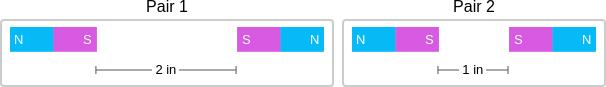

In [11]:
message = build_message(samples[100])
print(message)
print(message[0]['content'][0]['image'])  # 显示图像
message[0]['content'][0]['image'].show()  # 显示图像

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 加载模型和处理器
model = AutoModelForVision2Seq.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct",
    device_map={"": device},
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

Using device: cuda


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [17]:
import json
from tqdm import tqdm
import torch

results = []

for sample in tqdm(test_dataset):

    # 构造输入
    text = processor.apply_chat_template(sample, tokenize=False, add_generation_prompt=True)
    image_inputs = sample[0]['content'][0]['image']

    # 推理
    inputs = processor(text=[text], images=image_inputs, return_tensors="pt", padding=True).to(device)
    generated_ids = model.generate(**inputs, max_new_tokens=512)
    output = processor.batch_decode(generated_ids[:, inputs.input_ids.shape[-1]:], skip_special_tokens=True)[0]

    # 只保存输出
    results.append({
        "id": sample[0].get("id", str(image_inputs)),
        "model_out": output
    })

# 保存到新的 JSON 文件
with open("model_outputs_only_val.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)



100%|██████████| 1481/1481 [3:23:44<00:00,  8.25s/it]  


In [8]:
output

"The correct answer is: **A. black rockfish**. \n\nHere's the step-by-step reasoning:\n\n1. **Identify the starting point**: Phytoplankton is the starting point in the food web diagram.\n\n2. **Follow the arrows**: Arrows indicate the direction of matter movement from one organism to another.\n\n3. **Trace the path for black rockfish**:\n   - Phytoplankton -> zooplankton -> black rockfish\n\n4. **Verify the path for sea otter**:\n   - Phytoplankton -> zooplankton -> sea otter (but this path involves zooplankton, which is not directly connected to the sea otter in the diagram)\n\n5. **Conclusion**: The only path that leads from phytoplankton to an organism that appears in the diagram is through the black rockfish. Therefore, the black rockfish contains matter that was once part of the phytoplankton."